## QUERY LOCALIZER EXPERIMENT

Целью данного эксперимента является нахождение позы нового изображения на основе уже имеющейся реконструкции SfM. Здесь описан пайплайн, когда мы сами создаем SfM при помощи аппрата PixSfM. Вы можете также использовать уже готовую SfM.

# Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

from pathlib import Path
import pycolmap
import sys

sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, read_points3D_binary,\
        write_points3D_binary, write_images_binary, read_images_binary, write_images_text, read_cameras_binary, \
        Camera, write_cameras_text, read_cameras_text

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect

import numpy as np
from matplotlib import pyplot as plt

import open3d as o3d
assert o3d.__version__ == '0.15.2', 'The version 0.15.2 is required!'

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setup

В **object_name** необходимо задать имя объекта, над которым вы хотите провести эксперимент.

**check_for_calibrated_images** - булевая переменная, по которой мы выбираем какие поз камер использовать (менее точные (True) или точные (False))

**delete_previous_output** - если True, то удаляет все предыдущие файлы в папке outputs. Использовать супер осторожно.

In [2]:
object_name = 'dragon'

check_for_calibrated_images = False
delete_previous_output = False

**images_all** - путь к папке со всеми изображениями

**outputs** - путь к папке со всеми результатами

**cache_init** - путь к кэш-файлу, его мы получаем во время того, когда делаем KA или BA. В этот файле хранятся featuremaps после  dense feature extraction. В среднем на одну картинку размером 2368х1952 уходит 3 минуты. Этот файл вообще нельзя трогать, поэтому мы копируем его в папку outputs для своего эксперимента и продолжаем работу.

**cache_path** - тот же файл, что cache_init, с которым мы теперь будем работать во время эксперимента.

**sfm_pairs** - файл с названиями пар изображений на каждой строке

**features** - файл с features для каждой картинки, извлеченными при помощи feature_conf

**matches** - файл с matches для каждой пары картинок, извлеченными при помощи matcher_conf

**pairs-loc.txt** - файл с названиями пар изображений на каждой строке (только на этот раз идут пары для картинок из ДБ со всеми возможными картинками из папки query)

In [3]:
root = Path('/workspace')

images_all = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/undistorted/ambient@best'

# уточненные
images_init = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/images.txt'
cameras_init = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/cameras.txt'

outputs = root / (f'pixel-perfect-sfm/outputs/{object_name}/localization_known_cameras')

if delete_previous_output:
    !rm -rf $outputs
    
outputs.mkdir(parents=True, exist_ok=True)

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
loc_pairs = outputs / 'pairs-loc.txt'

exp_loc = outputs / "localizer"
exp_loc.mkdir(parents=True, exist_ok=True)

In [4]:
cache_init = root / f'pixel-perfect-sfm/outputs/caches/{object_name}/s2dnet_featuremaps_sparse.h5'
!cp -r $cache_init $outputs
cache_path = outputs / 's2dnet_featuremaps_sparse.h5'

# 3D mapping and refinement

Здесь описаны возможности для настройки [**extract_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/extract_features.py#L21)

Здесь описаны возможности для настройки [**match_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/match_features.py#L17)

Здесь описан пайплайн того, как можно использовать свои кастомные [**local features**, **matcher**, **image retrieval**](https://github.com/cvg/Hierarchical-Localization/tree/91f40bfd765add3b59ba7376f8579d8829f7fa78#using-your-own-local-features-or-matcher).


In [5]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Create db and query images

Создаем две папки: mapping и query. В папке mapping будут лежать все те картинки, которые нужны нам для построения реконструкции.  В папке query будут находиться все те картинки, для которых мы хотим новую позы.

In [6]:
import shutil

images = root / f'pixel-perfect-sfm/dataset/{object_name}_loc'
images.mkdir(parents=True, exist_ok=True)

images_references = root / f'pixel-perfect-sfm/dataset/{object_name}_loc/mapping'
images_references.mkdir(parents=True, exist_ok=True)
ref_num = 3

images_queries = root / f'pixel-perfect-sfm/dataset/{object_name}_loc/query'
images_queries.mkdir(parents=True, exist_ok=True)

img_list = sorted([str(p) for p in images_all.iterdir()])
for fn in img_list[:ref_num]: shutil.copy(fn, str(images_references)) 
for fn in img_list[ref_num:100]: shutil.copy(fn, str(images_queries)) 
    
!echo "All image references: " && ls $images_references
!echo "All image queries: " && ls $images_queries

All image references: 
0000.png  0001.png  0002.png
All image queries: 
0003.png  0016.png  0029.png  0042.png	0055.png  0068.png  0081.png  0094.png
0004.png  0017.png  0030.png  0043.png	0056.png  0069.png  0082.png  0095.png
0005.png  0018.png  0031.png  0044.png	0057.png  0070.png  0083.png  0096.png
0006.png  0019.png  0032.png  0045.png	0058.png  0071.png  0084.png  0097.png
0007.png  0020.png  0033.png  0046.png	0059.png  0072.png  0085.png  0098.png
0008.png  0021.png  0034.png  0047.png	0060.png  0073.png  0086.png  0099.png
0009.png  0022.png  0035.png  0048.png	0061.png  0074.png  0087.png
0010.png  0023.png  0036.png  0049.png	0062.png  0075.png  0088.png
0011.png  0024.png  0037.png  0050.png	0063.png  0076.png  0089.png
0012.png  0025.png  0038.png  0051.png	0064.png  0077.png  0090.png
0013.png  0026.png  0039.png  0052.png	0065.png  0078.png  0091.png
0014.png  0027.png  0040.png  0053.png	0066.png  0079.png  0092.png
0015.png  0028.png  0041.png  0054.png	0067.png  008

Здесь мы проверяем какие изображения мы будем использовать для построения реконструкции SfM.

['0000.png', '0001.png', '0002.png']
3 mapping images


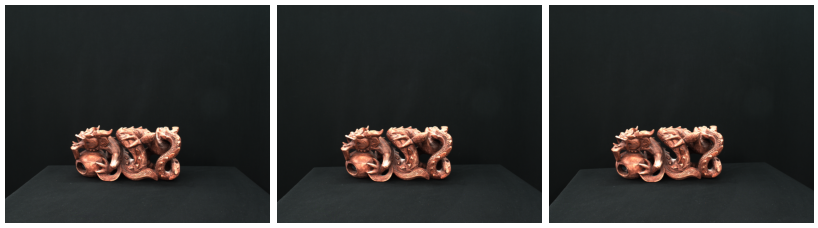

In [7]:
references = [str(p.relative_to(images_references)) for p in images_references.iterdir()]
print(references)
print(len(references), "mapping images")
plot_images([read_image(images_references / r) for r in references[:ref_num]], dpi=50)

**extract_features** - данная функция получает на вход *feature_conf*, *images* (путь к папке с изображениями), *image_list* (список тех изображений, которые вы хотите использовать для feature exctraction), *feature_path* (путь к файлу, где будет сохранен результат). На выходе получаем файл (**features**) с извлеченными features. Если **features** существует, то пропускается.

**pairs_from_exhaustive** - данная функция получает на вход *sfm_pairs* (путь к файлу, где будет сохранен результат), *image_list* (список тех изображений, при помощи которых вы сделаете exhaustive pairs.) На выходе получаем файл (**sfm_pairs**) с парами изображений.  Если **sfm_pairs** существует, то пропускается.

**match_features** - данная функция получает на вход *matcher_conf*, *sfm_pairs* (путь к файлу, где хранятся пары изображений после exhaustive pairing), *features* (путь к файлу, где хранятся извлеченный features для каждого изображения), *matches* (путь к файлу, где хранятся matches для каждой пары изображения). На выходе получаем файл (**matches**) с matches для каждой пары изображений . Если **match_features** существует, то пропускается.


In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["NVIDIA_VISIBLE_DEVICES"]="1"


import torch

print(torch.__version__)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device", device)

1.12.0+cu102


In [8]:
extract_features.main(feature_conf, 
                      images_all, 
                      image_list=references, 
                      feature_path=features)

pairs_from_exhaustive.main(sfm_pairs, 
                           image_list=references)

match_features.main(matcher_conf, 
                    sfm_pairs, 
                    features=features, 
                    matches=matches);

[2022/10/04 20:10:15 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/04 20:10:21 hloc INFO] Finished exporting features.
[2022/10/04 20:10:21 hloc INFO] Found 3 pairs.
[2022/10/04 20:10:21 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/04 20:10:22 hloc INFO] Finished exporting matches.


После того как мы получили features и matches для картинок из папки mapping, мы можем приступить к построению реконструкции при помощи PixSfM. 

Здесь описано как можно настроить конфигурацию для КА и ВА. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [9]:
!cp -r $images_init $exp_loc
print("images.txt copied!")

!cp -r $cameras_init $exp_loc
print("cameras.txt copied!")

!touch $exp_loc/points3D.txt
print("points3D.txt created!")

!ls $exp_loc

images.txt copied!
cameras.txt copied!
points3D.txt created!
cameras.txt  images.txt  points3D.txt


In [15]:
# put only 3 images into images.txt file

all_imgs = read_images_text(images_init)
found_imgs = {}
insert = 0
#all_imgs
for k, img in all_imgs.items():
    if insert == len(references):
        break
    if img.name in references:
        found_imgs[k] = img
        insert += 1

write_images_text(found_imgs, exp_loc / 'images.txt')        

In [17]:
check_model = pycolmap.Reconstruction(exp_loc)
print(check_model.summary())

Reconstruction:
	num_reg_images = 3
	num_cameras = 1
	num_points3D = 0
	num_observations = 0
	mean_track_length = 0
	mean_observations_per_image = 0
	mean_reprojection_error = 0


In [20]:
from pixsfm.refine_hloc import PixSfM
from pixsfm.refine_colmap import PixSfM as PixSfM_ba

# running Keypoint Adjustment
conf_KA = {
        "dense_features": {
                "use_cache": False,
        },
        "KA": {
            "dense_features": {'use_cache': True}, 
            "split_in_subproblems": True,
            "max_kps_per_problem": 1000,  
        },
}

refiner = PixSfM(conf=conf_KA)

keypoints_path = exp_loc / "refined_keypoints.h5"

keypoints, ka_data, feature_manager = refiner.refine_keypoints(
    output_path = keypoints_path,
    image_dir = images_references,
    features_path = features,
    pairs_path = sfm_pairs,
    matches_path = matches,
)

[2022/10/04 20:17:52 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/04 20:17:52 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}
[2022/10/04 20:17:52 pixsfm INFO] Building matching graph...
[2022/10/04 20:17:52 pixsfm INFO] Extracting dense features...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/04 20:17:54 pixsfm INFO] Computing tracks...
[2022/10/04 20:17:54 pixsfm INFO] # graph nodes: 1394
[2022/10/04 20:17:54 pixsfm INFO] # graph edges: 1217
[2022/10/04 20:17:54 pixsfm INFO] # tracks: 523
[2022/10/04 20:17:54 pixsfm INFO] Start feature-metric keypoint adjustment.


100%[████████████████████] 1394/1394 [00:00, 2520.79it/s]


[2022/10/04 20:17:54 pixsfm INFO] KA Time: 0.554036s, cost change: 0.0214498 --> 0.0157947


In [21]:
# https://github.com/cvg/pixel-perfect-sfm/blob/main/pixsfm/refine_hloc.py

try:
    import hloc
except ImportError:
    print("Could not import hloc.")
    hloc = None

In [23]:
hloc_path = exp_loc / 'hloc'
hloc_path.mkdir(parents=True, exist_ok=True)

database_path = hloc_path / 'database.db' 
reference = pycolmap.Reconstruction(exp_loc)   

images_txt_path = exp_loc / 'images.txt'
images_dict = read_images_text(images_txt_path)
        
# Here I changed code and in database we have data about camera extrinsics    
image_ids = hloc.triangulation.create_db_from_model(reference, 
                                                    database_path, 
                                                    images_dict)

#Importing features into database -> keypoints table 
hloc.triangulation.import_features(image_ids, 
                                   database_path, 
                                   keypoints_path)

#Importing matches into database -> matches table
skip_geometric_verification = False
hloc.triangulation.import_matches(image_ids, 
                                  database_path, 
                                  sfm_pairs, 
                                  matches,
                                  min_match_score=None, 
                                  skip_geometric_verification=skip_geometric_verification)

verbose, estimate_two_view_geometries = True, False

if not skip_geometric_verification:
        if estimate_two_view_geometries:
            hloc.triangulation.estimation_and_geometric_verification(database_path, 
                                                                     sfm_pairs, 
                                                                     verbose)
        else:
            # We are doing this part to add data to two_view_geometries table
            hloc.triangulation.geometric_verification(
                image_ids, 
                reference, 
                database_path, 
                keypoints_path, 
                sfm_pairs, 
                matches)
            
reconstruction = hloc.triangulation.run_triangulation(hloc_path, 
                                                      database_path, 
                                                      images, 
                                                      reference, 
                                                      verbose)

print(reconstruction.summary())  

# Saving result to a folder
reconstruction.write(str(hloc_path))

!mkdir -p $hloc_path/model_txt/

!colmap model_converter \
    --input_path $hloc_path \
    --output_path $hloc_path/model_txt/\
    --output_type TXT

[2022/10/04 20:18:46 hloc INFO] Images info from images dictionary.
[2022/10/04 20:18:46 hloc INFO] Importing features into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/04 20:18:46 hloc INFO] Importing matches into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/04 20:18:46 hloc INFO] Performing geometric verification of the matches...


  0%|          | 0/2 [00:00<?, ?it/s]

[2022/10/04 20:18:46 hloc INFO] mean/med/min/max valid matches 95.92/96.21/94.71/96.83%.
[2022/10/04 20:18:47 hloc INFO] Running 3D triangulation...



Loading database

Loading cameras... 1 in 0.001s
Loading matches... 3 in 0.001s
Loading images... 3 in 0.001s (connected 3)
Building correspondence graph... in 0.001s (ignored 0)

Elapsed time: 0.000 [minutes]


Triangulating image #1 (0)

  => Image sees 0 / 453 points
  => Triangulated 360 points

Triangulating image #2 (1)

  => Image sees 346 / 460 points
  => Triangulated 9 points

Triangulating image #3 (2)

  => Image sees 334 / 433 points
  => Triangulated 21 points

Retriangulation

  => Completed observations: 0
  => Merged observations: 0

Bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.381990e+02    0.00e+00    3.51e+04   0.00e+00   0.00e+00  1.00e+04        0    8.95e-04    1.93e-03
   1  4.902982e+02    1.48e+02    1.02e+03   3.48e-02   1.00e+00  3.00e+04        0    1.21e-03    3.64e-03
   2  4.902191e+02    7.90e-02    1.09e+00   9.98e-04   1.00e+00  9.00e+04        0    1.13e-03    

In [25]:
# compare images old and new, compare cameras old and new
images_old = read_images_text(exp_loc / 'images.txt')
images_new = read_images_binary(hloc_path / 'images.bin')

for i in range(1, len(references)+1):
    assert np.array_equal(images_old[i].tvec, images_new[i].tvec) == True
    assert np.allclose(np.array(images_old[i].qvec, dtype=np.float32), 
                          np.array(images_new[i].qvec, dtype=np.float32)) == True

In [27]:
# running featuremetric BA
conf_BA = {
        "BA": { 
                "apply": True,
                "optimizer": {
                      "refine_focal_length": False,  # whether to optimize the focal length
                      "refine_principal_point": False,  # whether to optimize the principal points
                      "refine_extra_params": False,  # whether to optimize distortion parameters
                      "refine_extrinsics": True,  # whether to optimize the camera poses
                }
            }
}

_cams = read_cameras_text(str(cameras_init))
f, cx, cy, k = _cams[0].params

opts = dict(camera_model='PINHOLE', 
            camera_params=','.join(map(str, (f, cx, cy, k))))

hloc_args = dict(camera_mode=pycolmap.CameraMode.SINGLE,
                verbose=True,
                image_options=opts)
print(hloc_args)

sfm = PixSfM_ba(conf=conf_BA)

model, ba_data, feature_manager2 = sfm.refine_reconstruction(
    output_path = exp_loc / 'hloc/model',
    input_path = exp_loc / 'hloc',
    image_dir = images_references,
)

print(model.summary())

!mkdir -p $exp_loc/hloc/model_txt/ 

!colmap model_converter \
    --input_path $exp_loc/hloc/ \
    --output_path $exp_loc/hloc/model_txt/ \
    --output_type TXT

{'camera_mode': <CameraMode.SINGLE: 1>, 'verbose': True, 'image_options': {'camera_model': 'PINHOLE', 'camera_params': '2316.555912757072,2318.7800234761503,1178.683483311831,978.7582365226921'}}


[2022/10/04 20:22:01 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/04 20:22:02 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}
[2022/10/04 20:22:02 pixsfm INFO] Extracting dense features...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/04 20:22:03 pixsfm INFO] Extracting references.


100%[████████████████████] 358/358 [00:00, 71600.0it/s]


[2022/10/04 20:22:03 pixsfm INFO] Reference Extraction Time: 0.041953s
[2022/10/04 20:22:03 pixsfm INFO] Start feature-reference bundle adjustment.


 38%[████████░░░░░░░░░░░░]  39/101 [00:00, 102.631it/s]


[2022/10/04 20:22:04 pixsfm INFO] BA Time: 0.380178s, cost change: 0.0135839 --> 0.0131905
Reconstruction:
	num_reg_images = 3
	num_cameras = 1
	num_points3D = 358
	num_observations = 1055
	mean_track_length = 2.94693
	mean_observations_per_image = 351.667
	mean_reprojection_error = 0.350055


## Localization

Здесь мы можем проверить для каких изображений мы хотим найти новые позы.

97  queries images
['0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0083.png', '0084.pn

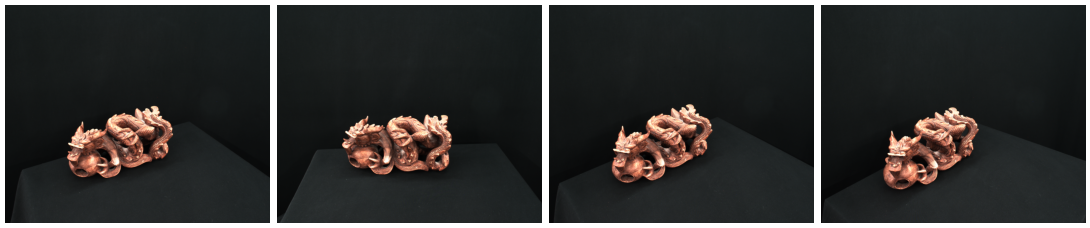

In [28]:
queries = [str(p.relative_to(images_queries)) for p in images_queries.iterdir()]
print(len(queries), " queries images")
print(sorted(queries))
plot_images([read_image(images_queries / r) for r in queries[:4]], dpi=50)

**features_query** - файл с features для каждой картинки из папки query, извлеченными при помощи feature_conf

**matches_query** - файл с matches для каждой пары картинок (mapping -> query), извлеченными при помощи matcher_conf

In [29]:
features_query = outputs / 'features_query.h5'
matches_query = outputs / 'matches_query.h5'

references_registered = [model.images[i].name for i in model.reg_image_ids()]

extract_features.main(feature_conf, 
                      images_all, 
                      image_list=queries, 
                      feature_path=features_query)

pairs_from_exhaustive.main(loc_pairs, 
                           image_list=queries, 
                           ref_list=references_registered)

[2022/10/04 20:22:23 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/97 [00:00<?, ?it/s]

[2022/10/04 20:22:41 hloc INFO] Finished exporting features.
[2022/10/04 20:22:41 hloc INFO] Found 291 pairs.


In [30]:
match_features.main(matcher_conf, 
                    loc_pairs, 
                    features=features_query, 
                    matches=matches_query, 
                    features_ref=features);

[2022/10/04 20:22:42 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/291 [00:00<?, ?it/s]

[2022/10/04 20:23:04 hloc INFO] Finished exporting matches.


На данном этапе мы создаем объект QueryLocalizer, который принимает *model* (pycolmap.Reconstruction объект, модель, на основе которой мы будем находить новые позы для изображений), *conf* (конфиг для query localizer), *dense_features* (dense features из SfM реконструкции).

Здесь описано как можно настроить конфигурацию для query localization. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [32]:
import pycolmap
from pixsfm.localize import QueryLocalizer, pose_from_cluster

loc_conf = {
        "dense_features": sfm.conf.dense_features,  # same features as the SfM refinement
        "PnP": {  # initial pose estimation with PnP+RANSAC
            'estimation': {'ransac': {'max_error': 12.0}},
            'refinement': {'refine_focal_length': False, 
                           'refine_extra_params': False},
        },
        "QBA": {  # query pose refinement
            "optimizer:": {'refine_focal_length': False, 
                           'refine_extra_params': False},
        }
    }


ref_ids = [model.find_image_with_name(r).image_id for r in references_registered]
dense_features = feature_manager2


# localizer computes references for the entire reconstruction at init
# Parameters:
# - config: Union[dict,DictConfig]: config of localization (use {} for default)
# - reconstruction: pycolmap.Reconstruction; reference COLMAP reconstruction
# - feature_manager: features of reference reconstruction

localizer = QueryLocalizer(model, 
                           conf=loc_conf, 
                           dense_features=dense_features)

[2022/10/04 20:23:29 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/04 20:23:30 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


[2022/10/04 20:23:30 pixsfm INFO] Extracting references.


100%[████████████████████] 358/358 [00:00, 51142.8it/s]


[2022/10/04 20:23:30 pixsfm INFO] Reference Extraction Time: 0.011511s


Объявляем какие параметры камеры мы хотим использовать для того чтобы локализовать query ихображение. Тут я использую камеру с теми же параметрами, которые использовались для построения SfM на основе изображений из папки mapping.

In [35]:
_cams = read_cameras_binary(str(exp_loc / 'hloc/cameras.bin'))
cam_info = _cams[0]
print(_cams[0])

pinhole_camera = pycolmap.Camera(
                            model='PINHOLE',
                            width=cam_info.width,
                            height=cam_info.height,
                            params=cam_info.params)
    
print("Camera info --> ", pinhole_camera)

result_dir = exp_loc / 'result'
result_dir.mkdir(parents=True, exist_ok=True)

Camera(id=0, model='PINHOLE', width=2368, height=1952, params=array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652]))
Camera info -->  <Camera 'camera_id=Invalid, model=PINHOLE, width=2368, height=1952, num_params=4'>


# Query Localization (1 query)

Находим позу для первого query изображения при помощи функции **pose_cluster**. Под капотом, QueryLocalizer извлекает dense features для query изображения и прогоняет QKA (query keypoint adjustment) и QBA (query pose adjustment).

In [36]:
query = sorted(queries)[0]

ret, log = pose_from_cluster(localizer, 
                             query, 
                             pinhole_camera, 
                             ref_ids, 
                             features_query, 
                             matches_query, 
                             image_path=images_all / query)

[2022/10/04 20:23:58 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:23:59 pixsfm INFO] Get references for this query.
[2022/10/04 20:23:59 pixsfm INFO] Run QKA


[2022/10/04 20:23:59 pixsfm INFO] QKA Time: 0.10181s, cost change: 0.0460087 --> 0.0278834


[2022/10/04 20:23:59 pixsfm INFO] Running PnP with 320 correspondences.
[2022/10/04 20:23:59 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:23:59 pixsfm INFO]  Run QBA


[2022/10/04 20:23:59 pixsfm INFO] QBA Time: 0.154657s, cost change: 0.017485 --> 0.0174806


[2022/10/04 20:23:59 pixsfm INFO] We recompute the inliers from the final pose


found 312/320 inlier correspondences.


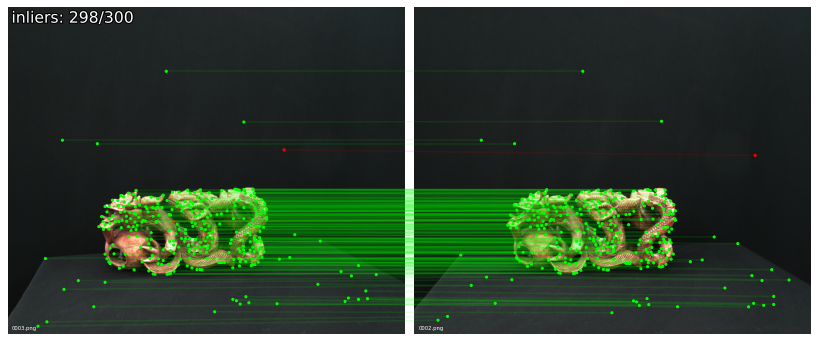

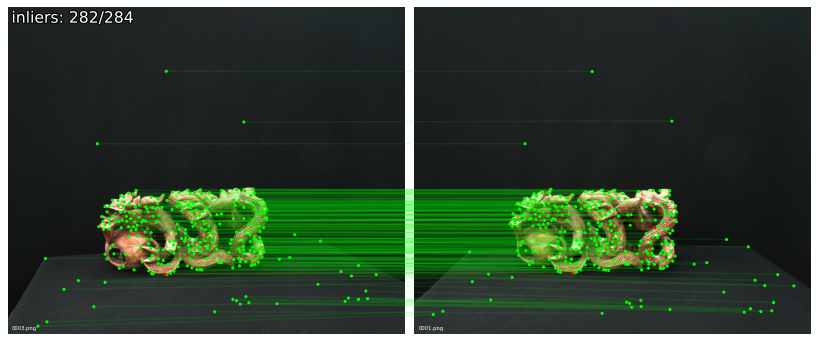

In [37]:
print(f'found {sum(ret["inliers"])}/{len(ret["inliers"])} inlier correspondences.')

visualization.visualize_loc_from_log(images_all, 
                         query, 
                         log, 
                         model, 
                         top_k_db=2)

# Visualization of first query

In [41]:
fig3d = init_figure()

camera_size = 0.01
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
plot_camera_colmap(fig3d, pose, pinhole_camera, color='rgba(128,128,255,0.5)', 
                   name=query, legendgroup="refined", size=camera_size)
args = dict(max_reproj_error=3.0, min_track_length=2, cs=camera_size)
plot_reconstruction(fig3d, model, color='rgba(0, 255, 0, 0.5)', name="model", **args)
fig3d.show()
fig3d.write_html(result_dir / "dragon_one_query_localizer.html")

# Query Localization (all queries)

Находим позу для всех query изображений при помощи функции **pose_cluster**. Под капотом, QueryLocalizer извлекает dense features для query изображения и прогоняет QKA (query keypoint adjustment) и QBA (query pose adjustment). Для нахождения позы в среднем на одну картинку размером 2368х1952 уходит 3 минуты.

In [42]:
result_dict = {}
extra_dict = {}

for k, query in enumerate(sorted(queries)):
    print(f'Current query image --> {query}')

    ret, log = pose_from_cluster(localizer, 
                                 query, 
                                 pinhole_camera, 
                                 ref_ids, 
                                 features_query, 
                                 matches_query, 
                                 image_path=images_all / query)    
    
    print("ret --> ", ret['qvec'], ret['tvec'], ret['camera'])

    image_id = int(Path(query).stem) + 1
    
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=ret['qvec'], 
                tvec=ret['tvec'],
                camera_id=cam_info.id, 
                name=query,
                xys= np.array([]), 
                point3D_ids= np.array([]),
    )
    
    extra_dict.update({
        'id': int(Path(query).stem) + 1,
        'qvec': ret['qvec'],
        'tvec': ret['tvec'],
        'camera': ret['camera'],
    })
    

[2022/10/04 20:26:22 pixsfm INFO] Start features exctraction.


Current query image --> 0003.png
None True


[2022/10/04 20:26:23 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:23 pixsfm INFO] Run QKA


[2022/10/04 20:26:23 pixsfm INFO] QKA Time: 0.072077s, cost change: 0.0460087 --> 0.0278834


[2022/10/04 20:26:23 pixsfm INFO] Running PnP with 320 correspondences.
[2022/10/04 20:26:23 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:23 pixsfm INFO]  Run QBA


[2022/10/04 20:26:23 pixsfm INFO] QBA Time: 0.127099s, cost change: 0.017485 --> 0.0174806


[2022/10/04 20:26:23 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:23 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98411384  0.02934085 -0.17504948 -0.00409249] [0.18185853 0.15002253 0.04046242] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0004.png
None True


[2022/10/04 20:26:24 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:24 pixsfm INFO] Run QKA


[2022/10/04 20:26:24 pixsfm INFO] QKA Time: 0.102291s, cost change: 0.0508937 --> 0.0331593


[2022/10/04 20:26:24 pixsfm INFO] Running PnP with 310 correspondences.
[2022/10/04 20:26:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:24 pixsfm INFO]  Run QBA


[2022/10/04 20:26:24 pixsfm INFO] QBA Time: 0.135194s, cost change: 0.0193183 --> 0.019314


[2022/10/04 20:26:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97630183  0.02897637 -0.21437703 -0.00613208] [0.23243933 0.14868895 0.05901549] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0005.png
None True


[2022/10/04 20:26:25 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:25 pixsfm INFO] Run QKA


[2022/10/04 20:26:25 pixsfm INFO] QKA Time: 0.060251s, cost change: 0.052318 --> 0.0365892


[2022/10/04 20:26:25 pixsfm INFO] Running PnP with 283 correspondences.
[2022/10/04 20:26:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:25 pixsfm INFO]  Run QBA


[2022/10/04 20:26:25 pixsfm INFO] QBA Time: 0.116807s, cost change: 0.0204265 --> 0.0204188


[2022/10/04 20:26:25 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:25 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96685523  0.02855865 -0.2535905  -0.00819846] [0.28163144 0.14705894 0.08173592] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0006.png
None True


[2022/10/04 20:26:25 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:25 pixsfm INFO] Run QKA


[2022/10/04 20:26:26 pixsfm INFO] QKA Time: 0.0815351s, cost change: 0.0545105 --> 0.0396215


[2022/10/04 20:26:26 pixsfm INFO] Running PnP with 275 correspondences.
[2022/10/04 20:26:26 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:26 pixsfm INFO]  Run QBA


[2022/10/04 20:26:26 pixsfm INFO] QBA Time: 0.186263s, cost change: 0.0215876 --> 0.0215638


[2022/10/04 20:26:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:26 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95586223  0.02810429 -0.2922876  -0.0102711 ] [0.328522   0.14514868 0.10832402] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0007.png
None True


[2022/10/04 20:26:26 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:26 pixsfm INFO] Run QKA


[2022/10/04 20:26:26 pixsfm INFO] QKA Time: 0.0842102s, cost change: 0.0563642 --> 0.042326


[2022/10/04 20:26:26 pixsfm INFO] Running PnP with 256 correspondences.
[2022/10/04 20:26:26 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:26 pixsfm INFO]  Run QBA


[2022/10/04 20:26:27 pixsfm INFO] QBA Time: 0.103018s, cost change: 0.0224233 --> 0.0224133


[2022/10/04 20:26:27 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94331309  0.02742538 -0.33053586 -0.0124223 ] [0.37302243 0.14251827 0.13857693] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0008.png
None True


[2022/10/04 20:26:27 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:27 pixsfm INFO] Run QKA


[2022/10/04 20:26:27 pixsfm INFO] QKA Time: 0.0673082s, cost change: 0.0586258 --> 0.0451217


[2022/10/04 20:26:27 pixsfm INFO] Running PnP with 247 correspondences.
[2022/10/04 20:26:27 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:27 pixsfm INFO]  Run QBA


[2022/10/04 20:26:27 pixsfm INFO] QBA Time: 0.087718s, cost change: 0.0229196 --> 0.0229009


[2022/10/04 20:26:27 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92937318  0.0270265  -0.36787256 -0.01431237] [0.41469214 0.14008634 0.17200633] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0009.png
None True


[2022/10/04 20:26:28 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:28 pixsfm INFO] Run QKA


[2022/10/04 20:26:28 pixsfm INFO] QKA Time: 0.112588s, cost change: 0.060038 --> 0.048093


[2022/10/04 20:26:28 pixsfm INFO] Running PnP with 228 correspondences.
[2022/10/04 20:26:28 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:28 pixsfm INFO]  Run QBA


[2022/10/04 20:26:28 pixsfm INFO] QBA Time: 0.121766s, cost change: 0.0234614 --> 0.0234182


[2022/10/04 20:26:28 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:28 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91377988  0.0265974  -0.40501302 -0.01622846] [0.45408389 0.13739521 0.20892674] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0010.png
None True


[2022/10/04 20:26:29 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:29 pixsfm INFO] Run QKA


[2022/10/04 20:26:29 pixsfm INFO] QKA Time: 0.0761139s, cost change: 0.0603097 --> 0.0487033


[2022/10/04 20:26:29 pixsfm INFO] Running PnP with 210 correspondences.
[2022/10/04 20:26:29 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:29 pixsfm INFO]  Run QBA


[2022/10/04 20:26:29 pixsfm INFO] QBA Time: 0.128411s, cost change: 0.0241971 --> 0.0241724


[2022/10/04 20:26:29 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.896916    0.02623911 -0.44105315 -0.01803657] [0.48971022 0.13475458 0.24875514] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0011.png


[2022/10/04 20:26:29 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:26:30 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:30 pixsfm INFO] Run QKA


[2022/10/04 20:26:30 pixsfm INFO] QKA Time: 0.0891731s, cost change: 0.0611364 --> 0.0496932


[2022/10/04 20:26:30 pixsfm INFO] Running PnP with 195 correspondences.
[2022/10/04 20:26:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:30 pixsfm INFO]  Run QBA


[2022/10/04 20:26:30 pixsfm INFO] QBA Time: 0.131165s, cost change: 0.0243619 --> 0.024337


[2022/10/04 20:26:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87843255  0.02538811 -0.47678029 -0.01980529] [0.52261572 0.13136448 0.29121331] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0012.png
None True


[2022/10/04 20:26:30 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:30 pixsfm INFO] Run QKA


[2022/10/04 20:26:30 pixsfm INFO] QKA Time: 0.0565109s, cost change: 0.0627915 --> 0.0520771


[2022/10/04 20:26:30 pixsfm INFO] Running PnP with 182 correspondences.
[2022/10/04 20:26:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:30 pixsfm INFO]  Run QBA


[2022/10/04 20:26:31 pixsfm INFO] QBA Time: 0.103601s, cost change: 0.0247209 --> 0.0247032


[2022/10/04 20:26:31 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:31 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85881075  0.05787285 -0.50724659 -0.04237609] [0.54927092 0.15311564 0.33972916] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0013.png
None True


[2022/10/04 20:26:31 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:31 pixsfm INFO] Run QKA


[2022/10/04 20:26:31 pixsfm INFO] QKA Time: 0.115792s, cost change: 0.0616021 --> 0.0506946


[2022/10/04 20:26:31 pixsfm INFO] Running PnP with 210 correspondences.
[2022/10/04 20:26:31 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:31 pixsfm INFO]  Run QBA


[2022/10/04 20:26:31 pixsfm INFO] QBA Time: 0.139679s, cost change: 0.024505 --> 0.0244937


[2022/10/04 20:26:31 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.87849311  0.05959085 -0.47238586 -0.03937483] [0.51962624 0.16029083 0.29571782] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0014.png


[2022/10/04 20:26:31 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:26:32 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:32 pixsfm INFO] Run QKA


[2022/10/04 20:26:32 pixsfm INFO] QKA Time: 0.0552511s, cost change: 0.0616663 --> 0.0505836


[2022/10/04 20:26:32 pixsfm INFO] Running PnP with 222 correspondences.
[2022/10/04 20:26:32 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:32 pixsfm INFO]  Run QBA


[2022/10/04 20:26:32 pixsfm INFO] QBA Time: 0.160626s, cost change: 0.0242665 --> 0.0242357


[2022/10/04 20:26:32 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89674806  0.06172352 -0.43675844 -0.03570968] [0.4865275  0.1679391  0.25349087] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0015.png
None True


[2022/10/04 20:26:33 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:33 pixsfm INFO] Run QKA


[2022/10/04 20:26:33 pixsfm INFO] QKA Time: 0.079464s, cost change: 0.0596198 --> 0.0476638


[2022/10/04 20:26:33 pixsfm INFO] Running PnP with 233 correspondences.
[2022/10/04 20:26:33 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:33 pixsfm INFO]  Run QBA


[2022/10/04 20:26:33 pixsfm INFO] QBA Time: 0.0875211s, cost change: 0.0236001 --> 0.0235636


[2022/10/04 20:26:33 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:33 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91377281  0.06307538 -0.39999005 -0.03238366] [0.44971631 0.17414274 0.21391109] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0016.png
None True


[2022/10/04 20:26:33 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:33 pixsfm INFO] Run QKA


[2022/10/04 20:26:33 pixsfm INFO] QKA Time: 0.0734591s, cost change: 0.059016 --> 0.0454116


[2022/10/04 20:26:33 pixsfm INFO] Running PnP with 243 correspondences.
[2022/10/04 20:26:33 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:33 pixsfm INFO]  Run QBA


[2022/10/04 20:26:34 pixsfm INFO] QBA Time: 0.216351s, cost change: 0.0230873 --> 0.0230387


[2022/10/04 20:26:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92906186  0.06394022 -0.36322173 -0.02873491] [0.41034756 0.1794549  0.17765977] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0017.png
None True


[2022/10/04 20:26:34 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:34 pixsfm INFO] Run QKA


[2022/10/04 20:26:34 pixsfm INFO] QKA Time: 0.0601089s, cost change: 0.0575768 --> 0.0430563


[2022/10/04 20:26:34 pixsfm INFO] Running PnP with 268 correspondences.
[2022/10/04 20:26:34 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:34 pixsfm INFO]  Run QBA


[2022/10/04 20:26:34 pixsfm INFO] QBA Time: 0.063941s, cost change: 0.0224145 --> 0.0223991


[2022/10/04 20:26:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9430537   0.06554776 -0.32513876 -0.02525864] [0.36761422 0.1853486  0.14443886] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0018.png
None True


[2022/10/04 20:26:35 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:35 pixsfm INFO] Run QKA


[2022/10/04 20:26:35 pixsfm INFO] QKA Time: 0.0788472s, cost change: 0.0552328 --> 0.0403778


[2022/10/04 20:26:35 pixsfm INFO] Running PnP with 281 correspondences.
[2022/10/04 20:26:35 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:35 pixsfm INFO]  Run QBA


[2022/10/04 20:26:35 pixsfm INFO] QBA Time: 0.195583s, cost change: 0.0218031 --> 0.0217911


[2022/10/04 20:26:35 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:35 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95556601  0.06647708 -0.28636465 -0.02167216] [0.32218524 0.18977096 0.11446485] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0019.png
None True


[2022/10/04 20:26:36 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:36 pixsfm INFO] Run QKA


[2022/10/04 20:26:36 pixsfm INFO] QKA Time: 0.070689s, cost change: 0.0537416 --> 0.0378898


[2022/10/04 20:26:36 pixsfm INFO] Running PnP with 298 correspondences.
[2022/10/04 20:26:36 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:36 pixsfm INFO]  Run QBA


[2022/10/04 20:26:36 pixsfm INFO] QBA Time: 0.175836s, cost change: 0.0208868 --> 0.0208796


[2022/10/04 20:26:36 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:36 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96635987  0.06759127 -0.24749442 -0.01807049] [0.27465376 0.19423403 0.08856085] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0020.png
None True


[2022/10/04 20:26:37 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:37 pixsfm INFO] Run QKA


[2022/10/04 20:26:37 pixsfm INFO] QKA Time: 0.069165s, cost change: 0.0498146 --> 0.0326271


[2022/10/04 20:26:37 pixsfm INFO] Running PnP with 307 correspondences.
[2022/10/04 20:26:37 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:37 pixsfm INFO]  Run QBA


[2022/10/04 20:26:37 pixsfm INFO] QBA Time: 0.0800271s, cost change: 0.0194239 --> 0.019408


[2022/10/04 20:26:37 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:37 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97564935  0.06825455 -0.20794456 -0.01444756] [0.22485828 0.19775712 0.06644107] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0021.png
None True


[2022/10/04 20:26:37 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:37 pixsfm INFO] Run QKA


[2022/10/04 20:26:38 pixsfm INFO] QKA Time: 0.0691209s, cost change: 0.0486593 --> 0.0295994


[2022/10/04 20:26:38 pixsfm INFO] Running PnP with 330 correspondences.
[2022/10/04 20:26:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:38 pixsfm INFO]  Run QBA


[2022/10/04 20:26:38 pixsfm INFO] QBA Time: 0.0900581s, cost change: 0.01831 --> 0.0183069


[2022/10/04 20:26:38 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:38 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98327643  0.06904133 -0.16818084 -0.01076813] [0.17316626 0.20055736 0.04840492] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0022.png
None True


[2022/10/04 20:26:38 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:38 pixsfm INFO] Run QKA


[2022/10/04 20:26:38 pixsfm INFO] QKA Time: 0.0509481s, cost change: 0.0447881 --> 0.0261066


[2022/10/04 20:26:38 pixsfm INFO] Running PnP with 346 correspondences.
[2022/10/04 20:26:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:38 pixsfm INFO]  Run QBA


[2022/10/04 20:26:38 pixsfm INFO] QBA Time: 0.227398s, cost change: 0.017168 --> 0.0171669


[2022/10/04 20:26:38 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98929841  0.06961784 -0.12803543 -0.00699527] [0.12051616 0.20306177 0.03465601] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0023.png
None True


[2022/10/04 20:26:39 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:39 pixsfm INFO] Run QKA


[2022/10/04 20:26:39 pixsfm INFO] QKA Time: 0.068331s, cost change: 0.0453362 --> 0.0257319


[2022/10/04 20:26:39 pixsfm INFO] Running PnP with 350 correspondences.
[2022/10/04 20:26:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:39 pixsfm INFO]  Run QBA


[2022/10/04 20:26:39 pixsfm INFO] QBA Time: 0.107443s, cost change: 0.0168805 --> 0.0168782


[2022/10/04 20:26:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9936765   0.0700788  -0.08766351 -0.00332955] [0.0667313  0.20455132 0.02503835] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0024.png
None True


[2022/10/04 20:26:40 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:40 pixsfm INFO] Run QKA


[2022/10/04 20:26:40 pixsfm INFO] QKA Time: 0.0736611s, cost change: 0.049693 --> 0.032972


[2022/10/04 20:26:40 pixsfm INFO] Running PnP with 321 correspondences.
[2022/10/04 20:26:40 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:40 pixsfm INFO]  Run QBA


[2022/10/04 20:26:40 pixsfm INFO] QBA Time: 0.120591s, cost change: 0.0192314 --> 0.0192209


[2022/10/04 20:26:40 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:40 pixsfm INFO] Start features exctraction.


ret -->  [ 0.99236438  0.11041042 -0.05489636 -0.00297837] [0.02305734 0.25686273 0.03557538] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0025.png
None True


[2022/10/04 20:26:41 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:41 pixsfm INFO] Run QKA


[2022/10/04 20:26:41 pixsfm INFO] QKA Time: 0.0730422s, cost change: 0.049376 --> 0.0305919


[2022/10/04 20:26:41 pixsfm INFO] Running PnP with 331 correspondences.
[2022/10/04 20:26:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:41 pixsfm INFO]  Run QBA


[2022/10/04 20:26:41 pixsfm INFO] QBA Time: 0.274271s, cost change: 0.0189842 --> 0.0189789


[2022/10/04 20:26:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98923907  0.1101793  -0.0958961  -0.00839795] [0.07822587 0.25544503 0.04177282] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0026.png
None True


[2022/10/04 20:26:42 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:42 pixsfm INFO] Run QKA


[2022/10/04 20:26:42 pixsfm INFO] QKA Time: 0.0538018s, cost change: 0.0484774 --> 0.0319585


[2022/10/04 20:26:42 pixsfm INFO] Running PnP with 322 correspondences.
[2022/10/04 20:26:42 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:42 pixsfm INFO]  Run QBA


[2022/10/04 20:26:42 pixsfm INFO] QBA Time: 0.105326s, cost change: 0.0189805 --> 0.0189715


[2022/10/04 20:26:42 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:42 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98447693  0.10930275 -0.13662097 -0.01388535] [0.13258729 0.25258293 0.05224658] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0027.png
None True


[2022/10/04 20:26:42 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:42 pixsfm INFO] Run QKA


[2022/10/04 20:26:42 pixsfm INFO] QKA Time: 0.0604131s, cost change: 0.0511366 --> 0.0348655


[2022/10/04 20:26:42 pixsfm INFO] Running PnP with 310 correspondences.
[2022/10/04 20:26:42 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:42 pixsfm INFO]  Run QBA


[2022/10/04 20:26:43 pixsfm INFO] QBA Time: 0.135331s, cost change: 0.0199321 --> 0.0199285


[2022/10/04 20:26:43 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.97796929  0.10840181 -0.17736091 -0.01918903] [0.18605743 0.24905915 0.06717011] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0028.png


[2022/10/04 20:26:43 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:26:43 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:43 pixsfm INFO] Run QKA


[2022/10/04 20:26:43 pixsfm INFO] QKA Time: 0.084533s, cost change: 0.0530774 --> 0.0377031


[2022/10/04 20:26:43 pixsfm INFO] Running PnP with 301 correspondences.
[2022/10/04 20:26:43 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:43 pixsfm INFO]  Run QBA


[2022/10/04 20:26:43 pixsfm INFO] QBA Time: 0.119651s, cost change: 0.0206607 --> 0.0206517


[2022/10/04 20:26:43 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.96984428  0.10719134 -0.21751248 -0.02450319] [0.23785126 0.24412068 0.08607626] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0029.png


[2022/10/04 20:26:43 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:26:44 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:44 pixsfm INFO] Run QKA


[2022/10/04 20:26:44 pixsfm INFO] QKA Time: 0.112674s, cost change: 0.053491 --> 0.040395


[2022/10/04 20:26:44 pixsfm INFO] Running PnP with 283 correspondences.
[2022/10/04 20:26:44 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:44 pixsfm INFO]  Run QBA


[2022/10/04 20:26:44 pixsfm INFO] QBA Time: 0.124275s, cost change: 0.0215882 --> 0.0215775


[2022/10/04 20:26:44 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:44 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96007443  0.10572217 -0.25727319 -0.02983991] [0.28791586 0.23825744 0.10919213] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0030.png
None True


[2022/10/04 20:26:45 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:45 pixsfm INFO] Run QKA


[2022/10/04 20:26:45 pixsfm INFO] QKA Time: 0.138576s, cost change: 0.0570273 --> 0.0425084


[2022/10/04 20:26:45 pixsfm INFO] Running PnP with 292 correspondences.
[2022/10/04 20:26:45 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:45 pixsfm INFO]  Run QBA


[2022/10/04 20:26:45 pixsfm INFO] QBA Time: 0.0984221s, cost change: 0.0223707 --> 0.0223584


[2022/10/04 20:26:45 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:45 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94863438  0.10404548 -0.29671347 -0.03504942] [0.33569917 0.23159547 0.13636283] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0031.png
None True


[2022/10/04 20:26:46 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:46 pixsfm INFO] Run QKA


[2022/10/04 20:26:46 pixsfm INFO] QKA Time: 0.120126s, cost change: 0.0589766 --> 0.0458359


[2022/10/04 20:26:46 pixsfm INFO] Running PnP with 264 correspondences.
[2022/10/04 20:26:46 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:46 pixsfm INFO]  Run QBA


[2022/10/04 20:26:46 pixsfm INFO] QBA Time: 0.155412s, cost change: 0.0231037 --> 0.0230695


[2022/10/04 20:26:46 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:46 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93550773  0.10263591 -0.33567714 -0.04014982] [0.38110075 0.22430563 0.16751877] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0032.png
None True


[2022/10/04 20:26:47 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:47 pixsfm INFO] Run QKA


[2022/10/04 20:26:47 pixsfm INFO] QKA Time: 0.0550449s, cost change: 0.0595295 --> 0.0462519


[2022/10/04 20:26:47 pixsfm INFO] Running PnP with 234 correspondences.
[2022/10/04 20:26:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:47 pixsfm INFO]  Run QBA


[2022/10/04 20:26:47 pixsfm INFO] QBA Time: 0.124711s, cost change: 0.0238118 --> 0.0237771


[2022/10/04 20:26:47 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:47 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92088487  0.10065931 -0.37387273 -0.04536462] [0.42363372 0.21577213 0.20166478] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0033.png
None True


[2022/10/04 20:26:47 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:47 pixsfm INFO] Run QKA


[2022/10/04 20:26:47 pixsfm INFO] QKA Time: 0.0825992s, cost change: 0.0608653 --> 0.0481695


[2022/10/04 20:26:47 pixsfm INFO] Running PnP with 234 correspondences.
[2022/10/04 20:26:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:47 pixsfm INFO]  Run QBA


[2022/10/04 20:26:48 pixsfm INFO] QBA Time: 0.077132s, cost change: 0.0239162 --> 0.0239107


[2022/10/04 20:26:48 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:48 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90492723  0.09856642 -0.41089404 -0.05057124] [0.46261027 0.20654556 0.23890554] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0034.png
None True


[2022/10/04 20:26:48 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:48 pixsfm INFO] Run QKA


[2022/10/04 20:26:48 pixsfm INFO] QKA Time: 0.117912s, cost change: 0.0623294 --> 0.0504015


[2022/10/04 20:26:48 pixsfm INFO] Running PnP with 206 correspondences.
[2022/10/04 20:26:48 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:48 pixsfm INFO]  Run QBA


[2022/10/04 20:26:48 pixsfm INFO] QBA Time: 0.113202s, cost change: 0.0245221 --> 0.0244793


[2022/10/04 20:26:48 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:48 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88716178  0.09643111 -0.44787737 -0.05523485] [0.49882842 0.19673688 0.27956548] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0035.png
None True


[2022/10/04 20:26:49 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:49 pixsfm INFO] Run QKA


[2022/10/04 20:26:49 pixsfm INFO] QKA Time: 0.067502s, cost change: 0.0633664 --> 0.0521209


[2022/10/04 20:26:49 pixsfm INFO] Running PnP with 196 correspondences.
[2022/10/04 20:26:49 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:49 pixsfm INFO]  Run QBA


[2022/10/04 20:26:49 pixsfm INFO] QBA Time: 0.209278s, cost change: 0.0248241 --> 0.0247902


[2022/10/04 20:26:49 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:49 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86823954  0.09401982 -0.48338336 -0.06050542] [0.53094629 0.18589051 0.32218819] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0036.png
None True


[2022/10/04 20:26:50 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:50 pixsfm INFO] Run QKA


[2022/10/04 20:26:50 pixsfm INFO] QKA Time: 0.096674s, cost change: 0.0654168 --> 0.0541745


[2022/10/04 20:26:50 pixsfm INFO] Running PnP with 178 correspondences.
[2022/10/04 20:26:50 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:50 pixsfm INFO]  Run QBA


[2022/10/04 20:26:50 pixsfm INFO] QBA Time: 0.222501s, cost change: 0.0252453 --> 0.0251671


[2022/10/04 20:26:50 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:50 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85168813  0.12632322 -0.50160289 -0.08404946] [0.54867429 0.20341505 0.36095728] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0037.png
None True


[2022/10/04 20:26:51 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:51 pixsfm INFO] Run QKA


[2022/10/04 20:26:51 pixsfm INFO] QKA Time: 0.114616s, cost change: 0.0636107 --> 0.0524676


[2022/10/04 20:26:51 pixsfm INFO] Running PnP with 211 correspondences.
[2022/10/04 20:26:51 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:51 pixsfm INFO]  Run QBA


[2022/10/04 20:26:51 pixsfm INFO] QBA Time: 0.22245s, cost change: 0.0250011 --> 0.0249689


[2022/10/04 20:26:51 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:51 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87111228  0.12985879 -0.46722365 -0.07747351] [0.51911656 0.21840415 0.31839916] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0038.png
None True


[2022/10/04 20:26:52 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:52 pixsfm INFO] Run QKA


[2022/10/04 20:26:52 pixsfm INFO] QKA Time: 0.0754631s, cost change: 0.0619506 --> 0.0515821


[2022/10/04 20:26:52 pixsfm INFO] Running PnP with 230 correspondences.
[2022/10/04 20:26:52 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:52 pixsfm INFO]  Run QBA


[2022/10/04 20:26:52 pixsfm INFO] QBA Time: 0.102729s, cost change: 0.0247464 --> 0.0247057


[2022/10/04 20:26:52 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:52 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89048235  0.13310238 -0.42929968 -0.07089943] [0.48335701 0.23296045 0.27513479] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0039.png
None True


[2022/10/04 20:26:52 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:52 pixsfm INFO] Run QKA


[2022/10/04 20:26:52 pixsfm INFO] QKA Time: 0.0735509s, cost change: 0.0613597 --> 0.0498382


[2022/10/04 20:26:52 pixsfm INFO] Running PnP with 235 correspondences.
[2022/10/04 20:26:52 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:52 pixsfm INFO]  Run QBA


[2022/10/04 20:26:53 pixsfm INFO] QBA Time: 0.143149s, cost change: 0.0242805 --> 0.0242551


[2022/10/04 20:26:53 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.90785778  0.13569103 -0.39146937 -0.06429561] [0.44464037 0.24569827 0.23582825] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0040.png


[2022/10/04 20:26:53 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:26:53 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:53 pixsfm INFO] Run QKA


[2022/10/04 20:26:53 pixsfm INFO] QKA Time: 0.109485s, cost change: 0.0598635 --> 0.0473029


[2022/10/04 20:26:53 pixsfm INFO] Running PnP with 259 correspondences.
[2022/10/04 20:26:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:53 pixsfm INFO]  Run QBA


[2022/10/04 20:26:53 pixsfm INFO] QBA Time: 0.188173s, cost change: 0.0238295 --> 0.0238106


[2022/10/04 20:26:53 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92353667  0.13855466 -0.35296374 -0.05743884] [0.40311016 0.25793257 0.19984338] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0041.png
None True


[2022/10/04 20:26:54 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:54 pixsfm INFO] Run QKA


[2022/10/04 20:26:54 pixsfm INFO] QKA Time: 0.081104s, cost change: 0.0577239 --> 0.0455315


[2022/10/04 20:26:54 pixsfm INFO] Running PnP with 264 correspondences.
[2022/10/04 20:26:54 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:54 pixsfm INFO]  Run QBA


[2022/10/04 20:26:54 pixsfm INFO] QBA Time: 0.108206s, cost change: 0.023166 --> 0.0231548


[2022/10/04 20:26:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93740332  0.1412837  -0.31429677 -0.05031372] [0.35846226 0.26914982 0.16766853] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0042.png
None True


[2022/10/04 20:26:55 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:55 pixsfm INFO] Run QKA


[2022/10/04 20:26:55 pixsfm INFO] QKA Time: 0.0838311s, cost change: 0.0565913 --> 0.0422157


[2022/10/04 20:26:55 pixsfm INFO] Running PnP with 269 correspondences.
[2022/10/04 20:26:55 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:55 pixsfm INFO]  Run QBA


[2022/10/04 20:26:55 pixsfm INFO] QBA Time: 0.1131s, cost change: 0.0226106 --> 0.0225905


[2022/10/04 20:26:55 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:55 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94999742  0.14324921 -0.27402791 -0.04351167] [0.3104195  0.27850924 0.13838085] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0043.png
None True


[2022/10/04 20:26:56 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:56 pixsfm INFO] Run QKA


[2022/10/04 20:26:56 pixsfm INFO] QKA Time: 0.116583s, cost change: 0.0545675 --> 0.0390258


[2022/10/04 20:26:56 pixsfm INFO] Running PnP with 284 correspondences.
[2022/10/04 20:26:56 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:56 pixsfm INFO]  Run QBA


[2022/10/04 20:26:56 pixsfm INFO] QBA Time: 0.111511s, cost change: 0.0217338 --> 0.0217255


[2022/10/04 20:26:56 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.96065105  0.14530021 -0.23388124 -0.03656464] [0.26037633 0.28701365 0.11358806] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0044.png


[2022/10/04 20:26:56 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:26:56 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:56 pixsfm INFO] Run QKA


[2022/10/04 20:26:56 pixsfm INFO] QKA Time: 0.061883s, cost change: 0.0539752 --> 0.0388338


[2022/10/04 20:26:56 pixsfm INFO] Running PnP with 296 correspondences.
[2022/10/04 20:26:57 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:57 pixsfm INFO]  Run QBA


[2022/10/04 20:26:57 pixsfm INFO] QBA Time: 0.121214s, cost change: 0.0210273 --> 0.0210159


[2022/10/04 20:26:57 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:57 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96967462  0.14695078 -0.19304788 -0.02948066] [0.20792316 0.29421695 0.09278135] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0045.png
None True


[2022/10/04 20:26:57 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:57 pixsfm INFO] Run QKA


[2022/10/04 20:26:57 pixsfm INFO] QKA Time: 0.099709s, cost change: 0.0522329 --> 0.0365547


[2022/10/04 20:26:57 pixsfm INFO] Running PnP with 301 correspondences.
[2022/10/04 20:26:57 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:57 pixsfm INFO]  Run QBA


[2022/10/04 20:26:57 pixsfm INFO] QBA Time: 0.141889s, cost change: 0.020533 --> 0.020526


[2022/10/04 20:26:57 pixsfm INFO] We recompute the inliers from the final pose


ret --> 

[2022/10/04 20:26:58 pixsfm INFO] Start features exctraction.


 [ 0.97697337  0.14826952 -0.15178148 -0.0223955 ] [0.1534971  0.29980491 0.07620817] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0046.png
None True


[2022/10/04 20:26:58 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:58 pixsfm INFO] Run QKA


[2022/10/04 20:26:58 pixsfm INFO] QKA Time: 0.0644939s, cost change: 0.052613 --> 0.0364253


[2022/10/04 20:26:58 pixsfm INFO] Running PnP with 317 correspondences.
[2022/10/04 20:26:58 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:58 pixsfm INFO]  Run QBA


[2022/10/04 20:26:58 pixsfm INFO] QBA Time: 0.160339s, cost change: 0.0205384 --> 0.0205353


[2022/10/04 20:26:58 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:58 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98243909  0.14960483 -0.11046542 -0.01514016] [0.09836536 0.30410505 0.06416541] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0047.png
None True


[2022/10/04 20:26:59 pixsfm INFO] Get references for this query.
[2022/10/04 20:26:59 pixsfm INFO] Run QKA


[2022/10/04 20:26:59 pixsfm INFO] QKA Time: 0.0810189s, cost change: 0.0505589 --> 0.0350243


[2022/10/04 20:26:59 pixsfm INFO] Running PnP with 299 correspondences.
[2022/10/04 20:26:59 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:26:59 pixsfm INFO]  Run QBA


[2022/10/04 20:26:59 pixsfm INFO] QBA Time: 0.169249s, cost change: 0.020514 --> 0.0205079


[2022/10/04 20:26:59 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:26:59 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98625782  0.15003693 -0.0686965  -0.00807569] [0.04192866 0.30644553 0.05640166] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0048.png
None True


[2022/10/04 20:27:00 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:00 pixsfm INFO] Run QKA


[2022/10/04 20:27:00 pixsfm INFO] QKA Time: 0.080781s, cost change: 0.0540579 --> 0.0385974


[2022/10/04 20:27:00 pixsfm INFO] Running PnP with 284 correspondences.
[2022/10/04 20:27:00 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:00 pixsfm INFO]  Run QBA


[2022/10/04 20:27:00 pixsfm INFO] QBA Time: 0.183353s, cost change: 0.0214622 --> 0.0214385


[2022/10/04 20:27:00 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:00 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98023072  0.1900661  -0.05436904 -0.00816245] [0.02317804 0.35598497 0.07805327] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0049.png
None True


[2022/10/04 20:27:01 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:01 pixsfm INFO] Run QKA


[2022/10/04 20:27:01 pixsfm INFO] QKA Time: 0.101259s, cost change: 0.052982 --> 0.0380118


[2022/10/04 20:27:01 pixsfm INFO] Running PnP with 299 correspondences.
[2022/10/04 20:27:01 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:01 pixsfm INFO]  Run QBA


[2022/10/04 20:27:01 pixsfm INFO] QBA Time: 0.174265s, cost change: 0.0213623 --> 0.0213455


[2022/10/04 20:27:01 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:01 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97697932  0.18921994 -0.0970083  -0.0172223 ] [0.08141148 0.35328481 0.08432222] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0050.png
None True


[2022/10/04 20:27:02 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:02 pixsfm INFO] Run QKA


[2022/10/04 20:27:02 pixsfm INFO] QKA Time: 0.0644681s, cost change: 0.0543885 --> 0.0392815


[2022/10/04 20:27:02 pixsfm INFO] Running PnP with 274 correspondences.
[2022/10/04 20:27:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:02 pixsfm INFO]  Run QBA


[2022/10/04 20:27:02 pixsfm INFO] QBA Time: 0.143599s, cost change: 0.021511 --> 0.0215062


[2022/10/04 20:27:02 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.97184149  0.18801454 -0.13958486 -0.02628162] [0.13891158 0.34841941 0.09504889] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0051.png


[2022/10/04 20:27:02 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:27:02 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:02 pixsfm INFO] Run QKA


[2022/10/04 20:27:02 pixsfm INFO] QKA Time: 0.0637789s, cost change: 0.0557441 --> 0.0402871


[2022/10/04 20:27:02 pixsfm INFO] Running PnP with 290 correspondences.
[2022/10/04 20:27:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:02 pixsfm INFO]  Run QBA


[2022/10/04 20:27:03 pixsfm INFO] QBA Time: 0.0677931s, cost change: 0.0217905 --> 0.0217833


[2022/10/04 20:27:03 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:03 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96489603  0.18619899 -0.18180984 -0.03536629] [0.19500785 0.34130859 0.11045227] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0052.png
None True


[2022/10/04 20:27:03 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:03 pixsfm INFO] Run QKA


[2022/10/04 20:27:03 pixsfm INFO] QKA Time: 0.081547s, cost change: 0.0565879 --> 0.041946


[2022/10/04 20:27:03 pixsfm INFO] Running PnP with 266 correspondences.
[2022/10/04 20:27:03 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:03 pixsfm INFO]  Run QBA


[2022/10/04 20:27:03 pixsfm INFO] QBA Time: 0.202849s, cost change: 0.0224039 --> 0.0223886


[2022/10/04 20:27:03 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:03 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95604442  0.18442569 -0.22361099 -0.04432097] [0.24931982 0.33306641 0.13039655] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0053.png
None True


[2022/10/04 20:27:04 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:04 pixsfm INFO] Run QKA


[2022/10/04 20:27:04 pixsfm INFO] QKA Time: 0.107092s, cost change: 0.0578883 --> 0.0441609


[2022/10/04 20:27:04 pixsfm INFO] Running PnP with 262 correspondences.
[2022/10/04 20:27:04 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:04 pixsfm INFO]  Run QBA


[2022/10/04 20:27:04 pixsfm INFO] QBA Time: 0.122443s, cost change: 0.0229932 --> 0.0229877


[2022/10/04 20:27:04 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:04 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94546844  0.1818254  -0.26492392 -0.05333178] [0.30172826 0.32242811 0.15444268] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0054.png
None True


[2022/10/04 20:27:05 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:05 pixsfm INFO] Run QKA


[2022/10/04 20:27:05 pixsfm INFO] QKA Time: 0.114546s, cost change: 0.0581375 --> 0.046114


[2022/10/04 20:27:05 pixsfm INFO] Running PnP with 269 correspondences.
[2022/10/04 20:27:05 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:05 pixsfm INFO]  Run QBA


[2022/10/04 20:27:05 pixsfm INFO] QBA Time: 0.122251s, cost change: 0.0234755 --> 0.0234683


[2022/10/04 20:27:05 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:05 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93296519  0.17893642 -0.30610312 -0.0621176 ] [0.3514734  0.31026489 0.18269051] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0055.png
None True


[2022/10/04 20:27:06 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:06 pixsfm INFO] Run QKA


[2022/10/04 20:27:06 pixsfm INFO] QKA Time: 0.0948639s, cost change: 0.0604007 --> 0.0490113


[2022/10/04 20:27:06 pixsfm INFO] Running PnP with 255 correspondences.
[2022/10/04 20:27:06 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:06 pixsfm INFO]  Run QBA


[2022/10/04 20:27:06 pixsfm INFO] QBA Time: 0.160387s, cost change: 0.0240002 --> 0.0239641


[2022/10/04 20:27:06 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.91882984  0.17640903 -0.34587755 -0.07071277] [0.3979876  0.2971139  0.21515145] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0056.png


[2022/10/04 20:27:06 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:27:07 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:07 pixsfm INFO] Run QKA


[2022/10/04 20:27:07 pixsfm INFO] QKA Time: 0.059664s, cost change: 0.0617489 --> 0.0507514


[2022/10/04 20:27:07 pixsfm INFO] Running PnP with 239 correspondences.
[2022/10/04 20:27:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:07 pixsfm INFO]  Run QBA


[2022/10/04 20:27:07 pixsfm INFO] QBA Time: 0.279907s, cost change: 0.0245889 --> 0.0245414


[2022/10/04 20:27:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90291     0.17264249 -0.38551442 -0.07954076] [0.44165015 0.28133289 0.25097675] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0057.png
None True


[2022/10/04 20:27:07 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:08 pixsfm INFO] Run QKA


[2022/10/04 20:27:08 pixsfm INFO] QKA Time: 0.0995588s, cost change: 0.0626382 --> 0.0527556


[2022/10/04 20:27:08 pixsfm INFO] Running PnP with 233 correspondences.
[2022/10/04 20:27:08 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:08 pixsfm INFO]  Run QBA


[2022/10/04 20:27:08 pixsfm INFO] QBA Time: 0.158298s, cost change: 0.0249049 --> 0.0248665


[2022/10/04 20:27:08 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:08 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88499485  0.16952446 -0.42471148 -0.08755419] [0.48183595 0.26558194 0.29007268] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0058.png
None True


[2022/10/04 20:27:08 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:08 pixsfm INFO] Run QKA


[2022/10/04 20:27:08 pixsfm INFO] QKA Time: 0.126473s, cost change: 0.0655994 --> 0.0547641


[2022/10/04 20:27:08 pixsfm INFO] Running PnP with 216 correspondences.
[2022/10/04 20:27:08 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:08 pixsfm INFO]  Run QBA


[2022/10/04 20:27:09 pixsfm INFO] QBA Time: 0.174469s, cost change: 0.0251982 --> 0.025159


[2022/10/04 20:27:09 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:09 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86562516  0.16550854 -0.46272175 -0.09585713] [0.51816842 0.24740483 0.33272389] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0059.png
None True


[2022/10/04 20:27:09 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:09 pixsfm INFO] Run QKA


[2022/10/04 20:27:09 pixsfm INFO] QKA Time: 0.111062s, cost change: 0.06699 --> 0.0578412


[2022/10/04 20:27:09 pixsfm INFO] Running PnP with 219 correspondences.
[2022/10/04 20:27:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:09 pixsfm INFO]  Run QBA


[2022/10/04 20:27:09 pixsfm INFO] QBA Time: 0.146709s, cost change: 0.0257937 --> 0.0256748


[2022/10/04 20:27:09 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.83884159  0.19355313 -0.49326451 -0.12478823] [0.54864406 0.24941937 0.39064235] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0060.png


[2022/10/04 20:27:10 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:27:10 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:10 pixsfm INFO] Run QKA


[2022/10/04 20:27:10 pixsfm INFO] QKA Time: 0.118293s, cost change: 0.0659324 --> 0.0565303


[2022/10/04 20:27:10 pixsfm INFO] Running PnP with 213 correspondences.
[2022/10/04 20:27:10 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:10 pixsfm INFO]  Run QBA


[2022/10/04 20:27:10 pixsfm INFO] QBA Time: 0.241084s, cost change: 0.025362 --> 0.0253032


[2022/10/04 20:27:10 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:10 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85959464  0.2009791  -0.45572041 -0.11411993] [0.51548499 0.27539019 0.34673169] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0061.png
None True


[2022/10/04 20:27:11 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:11 pixsfm INFO] Run QKA


[2022/10/04 20:27:11 pixsfm INFO] QKA Time: 0.109602s, cost change: 0.0647775 --> 0.0541281


[2022/10/04 20:27:11 pixsfm INFO] Running PnP with 231 correspondences.
[2022/10/04 20:27:11 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:11 pixsfm INFO]  Run QBA


[2022/10/04 20:27:11 pixsfm INFO] QBA Time: 0.107413s, cost change: 0.0251264 --> 0.0250436


[2022/10/04 20:27:11 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:11 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87915038  0.20507592 -0.41735406 -0.10418285] [0.47857279 0.2962568  0.3057806 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0062.png
None True


[2022/10/04 20:27:12 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:12 pixsfm INFO] Run QKA


[2022/10/04 20:27:12 pixsfm INFO] QKA Time: 0.0965099s, cost change: 0.0625218 --> 0.051259


[2022/10/04 20:27:12 pixsfm INFO] Running PnP with 258 correspondences.
[2022/10/04 20:27:12 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:12 pixsfm INFO]  Run QBA


[2022/10/04 20:27:12 pixsfm INFO] QBA Time: 0.162067s, cost change: 0.0245635 --> 0.0245329


[2022/10/04 20:27:12 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:12 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89732627  0.20930594 -0.37710312 -0.09375407] [0.43660258 0.31628731 0.26640844] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0063.png
None True


[2022/10/04 20:27:13 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:13 pixsfm INFO] Run QKA


[2022/10/04 20:27:13 pixsfm INFO] QKA Time: 0.143851s, cost change: 0.0611704 --> 0.0499809


[2022/10/04 20:27:13 pixsfm INFO] Running PnP with 243 correspondences.
[2022/10/04 20:27:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:13 pixsfm INFO]  Run QBA


[2022/10/04 20:27:13 pixsfm INFO] QBA Time: 0.172534s, cost change: 0.0243745 --> 0.0243277


[2022/10/04 20:27:13 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:13 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9134459   0.2137992  -0.33613083 -0.08320197] [0.39035437 0.33540813 0.23146266] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0064.png
None True


[2022/10/04 20:27:13 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:13 pixsfm INFO] Run QKA


[2022/10/04 20:27:14 pixsfm INFO] QKA Time: 0.10563s, cost change: 0.0600168 --> 0.047273


[2022/10/04 20:27:14 pixsfm INFO] Running PnP with 256 correspondences.
[2022/10/04 20:27:14 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:14 pixsfm INFO]  Run QBA


[2022/10/04 20:27:14 pixsfm INFO] QBA Time: 0.0820279s, cost change: 0.0236534 --> 0.0236409


[2022/10/04 20:27:14 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:14 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92764346  0.21741146 -0.2949333  -0.07227871] [0.34167455 0.35204929 0.20006615] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0065.png
None True


[2022/10/04 20:27:14 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:14 pixsfm INFO] Run QKA


[2022/10/04 20:27:14 pixsfm INFO] QKA Time: 0.110732s, cost change: 0.0592524 --> 0.0458504


[2022/10/04 20:27:14 pixsfm INFO] Running PnP with 255 correspondences.
[2022/10/04 20:27:14 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:14 pixsfm INFO]  Run QBA


[2022/10/04 20:27:15 pixsfm INFO] QBA Time: 0.249633s, cost change: 0.0233618 --> 0.0233389


[2022/10/04 20:27:15 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:15 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93995351  0.22083119 -0.25287049 -0.06146134] [0.28933813 0.3666793  0.17280084] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0066.png
None True


[2022/10/04 20:27:15 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:15 pixsfm INFO] Run QKA


[2022/10/04 20:27:15 pixsfm INFO] QKA Time: 0.0669389s, cost change: 0.0577662 --> 0.0454


[2022/10/04 20:27:15 pixsfm INFO] Running PnP with 260 correspondences.
[2022/10/04 20:27:15 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:15 pixsfm INFO]  Run QBA


[2022/10/04 20:27:16 pixsfm INFO] QBA Time: 0.146586s, cost change: 0.0226796 --> 0.0226636


[2022/10/04 20:27:16 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:16 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95040522  0.223533   -0.21027724 -0.05046182] [0.2345083  0.37905508 0.14991114] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0067.png
None True


[2022/10/04 20:27:16 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:16 pixsfm INFO] Run QKA


[2022/10/04 20:27:16 pixsfm INFO] QKA Time: 0.0660162s, cost change: 0.0572996 --> 0.0434953


[2022/10/04 20:27:16 pixsfm INFO] Running PnP with 266 correspondences.
[2022/10/04 20:27:16 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:16 pixsfm INFO]  Run QBA


[2022/10/04 20:27:16 pixsfm INFO] QBA Time: 0.0768559s, cost change: 0.0224081 --> 0.0223835


[2022/10/04 20:27:16 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:16 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95893935  0.22581026 -0.16699364 -0.03947378] [0.17725932 0.38883171 0.13132402] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0068.png
None True


[2022/10/04 20:27:17 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:17 pixsfm INFO] Run QKA


[2022/10/04 20:27:17 pixsfm INFO] QKA Time: 0.067821s, cost change: 0.0562533 --> 0.0420171


[2022/10/04 20:27:17 pixsfm INFO] Running PnP with 266 correspondences.
[2022/10/04 20:27:17 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:17 pixsfm INFO]  Run QBA


[2022/10/04 20:27:17 pixsfm INFO] QBA Time: 0.0986359s, cost change: 0.0221377 --> 0.0221083


[2022/10/04 20:27:17 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:17 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96559912  0.22721073 -0.12328838 -0.0281709 ] [0.11823205 0.39583693 0.11702878] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0069.png
None True


[2022/10/04 20:27:18 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:18 pixsfm INFO] Run QKA


[2022/10/04 20:27:18 pixsfm INFO] QKA Time: 0.114877s, cost change: 0.0563736 --> 0.0420388


[2022/10/04 20:27:18 pixsfm INFO] Running PnP with 278 correspondences.
[2022/10/04 20:27:18 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:18 pixsfm INFO]  Run QBA


[2022/10/04 20:27:18 pixsfm INFO] QBA Time: 0.240871s, cost change: 0.0221699 --> 0.0221359


[2022/10/04 20:27:18 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:18 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97011654  0.2286287  -0.07944615 -0.01706217] [0.05821439 0.40095315 0.10820662] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0070.png
None True


[2022/10/04 20:27:19 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:19 pixsfm INFO] Run QKA


[2022/10/04 20:27:19 pixsfm INFO] QKA Time: 0.105852s, cost change: 0.0571586 --> 0.043599


[2022/10/04 20:27:19 pixsfm INFO] Running PnP with 266 correspondences.
[2022/10/04 20:27:19 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:19 pixsfm INFO]  Run QBA


[2022/10/04 20:27:19 pixsfm INFO] QBA Time: 0.114605s, cost change: 0.0228927 --> 0.0228425


[2022/10/04 20:27:19 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:19 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9617624   0.26830202 -0.05345917 -0.01300871] [0.02364663 0.44704647 0.13581723] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0071.png
None True


[2022/10/04 20:27:19 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:19 pixsfm INFO] Run QKA


[2022/10/04 20:27:19 pixsfm INFO] QKA Time: 0.072351s, cost change: 0.0571196 --> 0.0437229


[2022/10/04 20:27:19 pixsfm INFO] Running PnP with 256 correspondences.
[2022/10/04 20:27:19 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:19 pixsfm INFO]  Run QBA


[2022/10/04 20:27:20 pixsfm INFO] QBA Time: 0.157328s, cost change: 0.0228926 --> 0.0228711


[2022/10/04 20:27:20 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:20 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95824689  0.26684085 -0.09927241 -0.02653026] [0.0870687  0.44241855 0.14209775] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0072.png
None True


[2022/10/04 20:27:20 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:20 pixsfm INFO] Run QKA


[2022/10/04 20:27:20 pixsfm INFO] QKA Time: 0.0695119s, cost change: 0.0575648 --> 0.0448885


[2022/10/04 20:27:20 pixsfm INFO] Running PnP with 251 correspondences.
[2022/10/04 20:27:20 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:20 pixsfm INFO]  Run QBA


[2022/10/04 20:27:21 pixsfm INFO] QBA Time: 0.137832s, cost change: 0.0230299 --> 0.0230071


[2022/10/04 20:27:21 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:21 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95254213  0.26493482 -0.14440518 -0.0402515 ] [0.14939542 0.43476037 0.15342935] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0073.png
None True


[2022/10/04 20:27:21 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:21 pixsfm INFO] Run QKA


[2022/10/04 20:27:21 pixsfm INFO] QKA Time: 0.089478s, cost change: 0.0584318 --> 0.0458931


[2022/10/04 20:27:21 pixsfm INFO] Running PnP with 247 correspondences.
[2022/10/04 20:27:21 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:21 pixsfm INFO]  Run QBA


[2022/10/04 20:27:21 pixsfm INFO] QBA Time: 0.146744s, cost change: 0.0231538 --> 0.0231365


[2022/10/04 20:27:21 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:21 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94468321  0.26245188 -0.18925418 -0.05362374] [0.20992263 0.42437865 0.16992096] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0074.png
None True


[2022/10/04 20:27:22 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:22 pixsfm INFO] Run QKA


[2022/10/04 20:27:22 pixsfm INFO] QKA Time: 0.11681s, cost change: 0.059673 --> 0.0466191


[2022/10/04 20:27:22 pixsfm INFO] Running PnP with 247 correspondences.
[2022/10/04 20:27:22 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:22 pixsfm INFO]  Run QBA


[2022/10/04 20:27:22 pixsfm INFO] QBA Time: 0.117801s, cost change: 0.0234477 --> 0.02342


[2022/10/04 20:27:22 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:22 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93458763  0.25952972 -0.23389642 -0.06695334] [0.26870376 0.41088339 0.19112415] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0075.png
None True


[2022/10/04 20:27:23 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:23 pixsfm INFO] Run QKA


[2022/10/04 20:27:23 pixsfm INFO] QKA Time: 0.0765769s, cost change: 0.0601945 --> 0.0484905


[2022/10/04 20:27:23 pixsfm INFO] Running PnP with 240 correspondences.
[2022/10/04 20:27:23 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:23 pixsfm INFO]  Run QBA


[2022/10/04 20:27:23 pixsfm INFO] QBA Time: 0.0943692s, cost change: 0.0239726 --> 0.0239481


[2022/10/04 20:27:23 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:23 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92244636  0.25566587 -0.27803995 -0.08013398] [0.32464142 0.3941992  0.21687832] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0076.png
None True


[2022/10/04 20:27:23 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:23 pixsfm INFO] Run QKA


[2022/10/04 20:27:24 pixsfm INFO] QKA Time: 0.109372s, cost change: 0.0623209 --> 0.0509829


[2022/10/04 20:27:24 pixsfm INFO] Running PnP with 250 correspondences.
[2022/10/04 20:27:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:24 pixsfm INFO]  Run QBA


[2022/10/04 20:27:24 pixsfm INFO] QBA Time: 0.116352s, cost change: 0.0244277 --> 0.0243971


[2022/10/04 20:27:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90808621  0.25188578 -0.32133917 -0.09313497] [0.37725866 0.3755841  0.24785281] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0077.png
None True


[2022/10/04 20:27:24 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:24 pixsfm INFO] Run QKA


[2022/10/04 20:27:24 pixsfm INFO] QKA Time: 0.0969918s, cost change: 0.0633071 --> 0.051956


[2022/10/04 20:27:24 pixsfm INFO] Running PnP with 233 correspondences.
[2022/10/04 20:27:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:24 pixsfm INFO]  Run QBA


[2022/10/04 20:27:25 pixsfm INFO] QBA Time: 0.14631s, cost change: 0.0247658 --> 0.0247331


[2022/10/04 20:27:25 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:25 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89216612  0.24631057 -0.36344983 -0.10618355] [0.42591319 0.35290371 0.28131211] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0078.png
None True


[2022/10/04 20:27:25 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:25 pixsfm INFO] Run QKA


[2022/10/04 20:27:25 pixsfm INFO] QKA Time: 0.081135s, cost change: 0.0653519 --> 0.0550954


[2022/10/04 20:27:25 pixsfm INFO] Running PnP with 235 correspondences.
[2022/10/04 20:27:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:25 pixsfm INFO]  Run QBA


[2022/10/04 20:27:25 pixsfm INFO] QBA Time: 0.147416s, cost change: 0.0250724 --> 0.025058


[2022/10/04 20:27:25 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:25 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87362625  0.24115282 -0.4056064  -0.11876846] [0.47111363 0.32898898 0.31993431] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0079.png
None True


[2022/10/04 20:27:26 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:26 pixsfm INFO] Run QKA


[2022/10/04 20:27:26 pixsfm INFO] QKA Time: 0.096884s, cost change: 0.0658425 --> 0.0565814


[2022/10/04 20:27:26 pixsfm INFO] Running PnP with 225 correspondences.
[2022/10/04 20:27:26 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:26 pixsfm INFO]  Run QBA


[2022/10/04 20:27:26 pixsfm INFO] QBA Time: 0.233854s, cost change: 0.0256435 --> 0.0255115


[2022/10/04 20:27:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:26 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85366147  0.2348139  -0.44602862 -0.13108388] [0.51117752 0.30226018 0.36042177] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0080.png
None True


[2022/10/04 20:27:27 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:27 pixsfm INFO] Run QKA


[2022/10/04 20:27:27 pixsfm INFO] QKA Time: 0.110883s, cost change: 0.0672299 --> 0.05761


[2022/10/04 20:27:27 pixsfm INFO] Running PnP with 166 correspondences.
[2022/10/04 20:27:27 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:27 pixsfm INFO]  Run QBA


[2022/10/04 20:27:27 pixsfm INFO] QBA Time: 0.109354s, cost change: 0.0258043 --> 0.0257319


[2022/10/04 20:27:27 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.83296008  0.2277381  -0.48341257 -0.14361458] [0.54498587 0.27408755 0.40298566] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0081.png
None True


[2022/10/04 20:27:28 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:28 pixsfm INFO] Run QKA


[2022/10/04 20:27:28 pixsfm INFO] QKA Time: 0.077142s, cost change: 0.0672961 --> 0.0578713


[2022/10/04 20:27:28 pixsfm INFO] Running PnP with 119 correspondences.
[2022/10/04 20:27:28 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:28 pixsfm INFO]  Run QBA


[2022/10/04 20:27:28 pixsfm INFO] QBA Time: 0.0811641s, cost change: 0.0257235 --> 0.0255819


[2022/10/04 20:27:28 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:28 pixsfm INFO] Start features exctraction.


ret -->  [ 0.82044663  0.26177633 -0.4812369  -0.16355893] [0.5481525  0.29353125 0.42780023] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0082.png
None True


[2022/10/04 20:27:28 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:28 pixsfm INFO] Run QKA


[2022/10/04 20:27:29 pixsfm INFO] QKA Time: 0.0861571s, cost change: 0.0654768 --> 0.0561546


[2022/10/04 20:27:29 pixsfm INFO] Running PnP with 200 correspondences.
[2022/10/04 20:27:29 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:29 pixsfm INFO]  Run QBA


[2022/10/04 20:27:29 pixsfm INFO] QBA Time: 0.185435s, cost change: 0.0256088 --> 0.0255485


[2022/10/04 20:27:29 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:29 pixsfm INFO] Start features exctraction.


ret -->  [ 0.84317983  0.26878384 -0.44097937 -0.14946642] [0.51180106 0.32552763 0.38343716] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0083.png
None True


[2022/10/04 20:27:29 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:29 pixsfm INFO] Run QKA


[2022/10/04 20:27:29 pixsfm INFO] QKA Time: 0.105638s, cost change: 0.0645369 --> 0.0553883


[2022/10/04 20:27:29 pixsfm INFO] Running PnP with 231 correspondences.
[2022/10/04 20:27:29 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:29 pixsfm INFO]  Run QBA


[2022/10/04 20:27:30 pixsfm INFO] QBA Time: 0.15126s, cost change: 0.0253514 --> 0.0253168


[2022/10/04 20:27:30 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.86384531  0.27582687 -0.39936246 -0.13490899] [0.47003231 0.35614587 0.34253499] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0084.png


[2022/10/04 20:27:30 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:27:30 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:30 pixsfm INFO] Run QKA


[2022/10/04 20:27:30 pixsfm INFO] QKA Time: 0.100915s, cost change: 0.064389 --> 0.0546759


[2022/10/04 20:27:30 pixsfm INFO] Running PnP with 250 correspondences.
[2022/10/04 20:27:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:30 pixsfm INFO]  Run QBA


[2022/10/04 20:27:30 pixsfm INFO] QBA Time: 0.177598s, cost change: 0.024877 --> 0.024837


[2022/10/04 20:27:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88270887  0.28242038 -0.35601963 -0.11964031] [0.42257753 0.38497401 0.3047788 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0085.png
None True


[2022/10/04 20:27:31 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:31 pixsfm INFO] Run QKA


[2022/10/04 20:27:31 pixsfm INFO] QKA Time: 0.0841479s, cost change: 0.0628464 --> 0.0516593


[2022/10/04 20:27:31 pixsfm INFO] Running PnP with 240 correspondences.
[2022/10/04 20:27:31 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:31 pixsfm INFO]  Run QBA


[2022/10/04 20:27:31 pixsfm INFO] QBA Time: 0.132822s, cost change: 0.0246605 --> 0.024574


[2022/10/04 20:27:31 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:31 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89961992  0.28814945 -0.31110339 -0.10425251] [0.36999144 0.41051617 0.27029534] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0086.png
None True


[2022/10/04 20:27:32 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:32 pixsfm INFO] Run QKA


[2022/10/04 20:27:32 pixsfm INFO] QKA Time: 0.0938599s, cost change: 0.0620946 --> 0.0504588


[2022/10/04 20:27:32 pixsfm INFO] Running PnP with 247 correspondences.
[2022/10/04 20:27:32 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:32 pixsfm INFO]  Run QBA


[2022/10/04 20:27:32 pixsfm INFO] QBA Time: 0.107725s, cost change: 0.0243254 --> 0.0243173


[2022/10/04 20:27:32 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91415894  0.29286298 -0.26583934 -0.08873643] [0.3138202  0.43281394 0.2410233 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0087.png
None True


[2022/10/04 20:27:33 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:33 pixsfm INFO] Run QKA


[2022/10/04 20:27:33 pixsfm INFO] QKA Time: 0.117767s, cost change: 0.0600455 --> 0.047767


[2022/10/04 20:27:33 pixsfm INFO] Running PnP with 256 correspondences.
[2022/10/04 20:27:33 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:33 pixsfm INFO]  Run QBA


[2022/10/04 20:27:33 pixsfm INFO] QBA Time: 0.168516s, cost change: 0.023863 --> 0.0238568


[2022/10/04 20:27:33 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:33 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92626277  0.29725634 -0.219884   -0.0729861 ] [0.25406022 0.45170932 0.21660526] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0088.png
None True


[2022/10/04 20:27:33 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:33 pixsfm INFO] Run QKA


[2022/10/04 20:27:33 pixsfm INFO] QKA Time: 0.058665s, cost change: 0.059718 --> 0.0468405


[2022/10/04 20:27:33 pixsfm INFO] Running PnP with 234 correspondences.
[2022/10/04 20:27:33 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:33 pixsfm INFO]  Run QBA


[2022/10/04 20:27:34 pixsfm INFO] QBA Time: 0.0833201s, cost change: 0.0236497 --> 0.0236304


[2022/10/04 20:27:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93598108  0.30107834 -0.17338916 -0.05681063] [0.19161919 0.46737973 0.19691187] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0089.png
None True


[2022/10/04 20:27:34 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:34 pixsfm INFO] Run QKA


[2022/10/04 20:27:34 pixsfm INFO] QKA Time: 0.079612s, cost change: 0.0592835 --> 0.0466709


[2022/10/04 20:27:34 pixsfm INFO] Running PnP with 229 correspondences.
[2022/10/04 20:27:34 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:34 pixsfm INFO]  Run QBA


[2022/10/04 20:27:34 pixsfm INFO] QBA Time: 0.0874491s, cost change: 0.0233999 --> 0.0233836


[2022/10/04 20:27:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94354656  0.30350615 -0.12634425 -0.04050977] [0.1266775  0.47835778 0.1818498 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0090.png
None True


[2022/10/04 20:27:35 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:35 pixsfm INFO] Run QKA


[2022/10/04 20:27:35 pixsfm INFO] QKA Time: 0.082659s, cost change: 0.0579909 --> 0.0462499


[2022/10/04 20:27:35 pixsfm INFO] Running PnP with 241 correspondences.
[2022/10/04 20:27:35 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:35 pixsfm INFO]  Run QBA


[2022/10/04 20:27:35 pixsfm INFO] QBA Time: 0.154542s, cost change: 0.0233672 --> 0.0233214


[2022/10/04 20:27:35 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:35 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94848172  0.3059072  -0.07875971 -0.0244974 ] [0.06031327 0.48638604 0.17267125] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0091.png
None True


[2022/10/04 20:27:36 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:36 pixsfm INFO] Run QKA


[2022/10/04 20:27:36 pixsfm INFO] QKA Time: 0.0852549s, cost change: 0.0588232 --> 0.0472473


[2022/10/04 20:27:36 pixsfm INFO] Running PnP with 232 correspondences.
[2022/10/04 20:27:36 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:36 pixsfm INFO]  Run QBA


[2022/10/04 20:27:36 pixsfm INFO] QBA Time: 0.188026s, cost change: 0.0239944 --> 0.0239324


[2022/10/04 20:27:36 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:36 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93735444  0.34398052 -0.0521593  -0.01798491] [0.02373714 0.52679984 0.20645047] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0092.png
None True


[2022/10/04 20:27:37 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:37 pixsfm INFO] Run QKA


[2022/10/04 20:27:37 pixsfm INFO] QKA Time: 0.0846119s, cost change: 0.0593614 --> 0.0469964


[2022/10/04 20:27:37 pixsfm INFO] Running PnP with 223 correspondences.
[2022/10/04 20:27:37 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:37 pixsfm INFO]  Run QBA


[2022/10/04 20:27:37 pixsfm INFO] QBA Time: 0.228541s, cost change: 0.0238954 --> 0.0238425


[2022/10/04 20:27:37 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:37 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93323073  0.34234114 -0.10239419 -0.03739479] [0.09561455 0.52057231 0.21333552] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0093.png
None True


[2022/10/04 20:27:38 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:38 pixsfm INFO] Run QKA


[2022/10/04 20:27:38 pixsfm INFO] QKA Time: 0.060945s, cost change: 0.0579463 --> 0.0467561


[2022/10/04 20:27:38 pixsfm INFO] Running PnP with 226 correspondences.
[2022/10/04 20:27:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:38 pixsfm INFO]  Run QBA


[2022/10/04 20:27:38 pixsfm INFO] QBA Time: 0.148741s, cost change: 0.0237413 --> 0.0236957


[2022/10/04 20:27:38 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.92639351  0.33958317 -0.15255314 -0.05662039] [0.16617049 0.5092465  0.22607337] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0094.png


[2022/10/04 20:27:38 pixsfm INFO] Start features exctraction.


None True


[2022/10/04 20:27:38 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:38 pixsfm INFO] Run QKA


[2022/10/04 20:27:38 pixsfm INFO] QKA Time: 0.108397s, cost change: 0.059226 --> 0.0486672


[2022/10/04 20:27:38 pixsfm INFO] Running PnP with 227 correspondences.
[2022/10/04 20:27:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:39 pixsfm INFO]  Run QBA


[2022/10/04 20:27:39 pixsfm INFO] QBA Time: 0.14968s, cost change: 0.0241523 --> 0.0240792


[2022/10/04 20:27:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9170451   0.33569285 -0.20146387 -0.07583468] [0.23363367 0.49292542 0.24390792] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0095.png
None True


[2022/10/04 20:27:39 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:39 pixsfm INFO] Run QKA


[2022/10/04 20:27:39 pixsfm INFO] QKA Time: 0.063879s, cost change: 0.0609458 --> 0.0495452


[2022/10/04 20:27:39 pixsfm INFO] Running PnP with 240 correspondences.
[2022/10/04 20:27:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:39 pixsfm INFO]  Run QBA


[2022/10/04 20:27:40 pixsfm INFO] QBA Time: 0.207218s, cost change: 0.0244993 --> 0.0244783


[2022/10/04 20:27:40 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:40 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90493453  0.33099969 -0.25001673 -0.09499648] [0.29840708 0.47206785 0.26734938] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0096.png
None True


[2022/10/04 20:27:40 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:40 pixsfm INFO] Run QKA


[2022/10/04 20:27:40 pixsfm INFO] QKA Time: 0.0869451s, cost change: 0.0629291 --> 0.0527512


[2022/10/04 20:27:40 pixsfm INFO] Running PnP with 227 correspondences.
[2022/10/04 20:27:40 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:40 pixsfm INFO]  Run QBA


[2022/10/04 20:27:40 pixsfm INFO] QBA Time: 0.155377s, cost change: 0.0248741 --> 0.024832


[2022/10/04 20:27:40 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:40 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89032948  0.32538525 -0.29748966 -0.11374426] [0.35888682 0.44683103 0.29525668] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0097.png
None True


[2022/10/04 20:27:41 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:41 pixsfm INFO] Run QKA


[2022/10/04 20:27:41 pixsfm INFO] QKA Time: 0.122226s, cost change: 0.0645249 --> 0.0549451


[2022/10/04 20:27:41 pixsfm INFO] Running PnP with 219 correspondences.
[2022/10/04 20:27:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:41 pixsfm INFO]  Run QBA


[2022/10/04 20:27:41 pixsfm INFO] QBA Time: 0.150666s, cost change: 0.0251878 --> 0.0251245


[2022/10/04 20:27:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87330494  0.3181801  -0.34438632 -0.1322799 ] [0.41545258 0.41671311 0.32820395] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0098.png
None True


[2022/10/04 20:27:42 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:42 pixsfm INFO] Run QKA


[2022/10/04 20:27:42 pixsfm INFO] QKA Time: 0.12691s, cost change: 0.0645235 --> 0.055054


[2022/10/04 20:27:42 pixsfm INFO] Running PnP with 182 correspondences.
[2022/10/04 20:27:42 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:42 pixsfm INFO]  Run QBA


[2022/10/04 20:27:42 pixsfm INFO] QBA Time: 0.19433s, cost change: 0.0252702 --> 0.025171


[2022/10/04 20:27:42 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/04 20:27:42 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85239582  0.31213849 -0.39205356 -0.14928139] [0.46818194 0.38471929 0.36788895] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}
Current query image --> 0099.png
None True


[2022/10/04 20:27:43 pixsfm INFO] Get references for this query.
[2022/10/04 20:27:43 pixsfm INFO] Run QKA


[2022/10/04 20:27:43 pixsfm INFO] QKA Time: 0.0514259s, cost change: 0.0649459 --> 0.0553532


[2022/10/04 20:27:43 pixsfm INFO] Running PnP with 67 correspondences.
[2022/10/04 20:27:43 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/04 20:27:43 pixsfm INFO]  Run QBA


[2022/10/04 20:27:43 pixsfm INFO] QBA Time: 0.116377s, cost change: 0.0255981 --> 0.0255613


[2022/10/04 20:27:43 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.83135473  0.30337519 -0.43482528 -0.16655267] [0.5116152  0.34850002 0.40775072] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2316.55591276, 2318.78002348, 1178.68348331,  978.75823652])}


Ниже описано в какой папке сохраняется файл со всеми позами из SfM и новыми query.

In [43]:
images_dict = read_images_binary(str(exp_loc / 'hloc/images.bin'))

for val in images_dict.values():
    image_id = int(Path(val.name).stem) + 1
    qvec = val.qvec
    tvec = val.tvec
    camera_id = val.camera_id
    image_name = val.name
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=qvec, 
                tvec=tvec,
                camera_id=camera_id, 
                name=image_name,
                xys=np.array([]), 
                point3D_ids=np.array([]))
    
print(len(result_dict)) 


write_images_text(result_dict, result_dir / 'images.txt')
write_cameras_text(_cams, result_dir / 'cameras.txt')

100


In [46]:
!ls $result_dir

cameras.txt			 dragon_query_localizer.html
dragon_one_query_localizer.html  images.txt


# Visualization of all queries

Здесь изображены все найденные позы для query изображений, рядом с ними также расположена SfM.

In [45]:
camera_size = 0.01

args = dict(max_reproj_error=3.0, min_track_length=2, cs=camera_size)



fig3d = init_figure()
for index, ret in result_dict.items():
    pose = pycolmap.Image(tvec=ret.tvec, qvec=ret.qvec)
    plot_camera_colmap(fig3d, pose, pinhole_camera, color='rgba(128,128,255,0.5)', 
                       name=ret.name, legendgroup="refined", size=camera_size)
plot_reconstruction(fig3d, model, color='rgba(0, 255, 0, 0.5)', name="model", **args)
    
fig3d.show()
fig3d.write_html(result_dir / "dragon_query_localizer.html")